# Projeto de Conclusão Turing Academy

Este projeto tem como finalidade mostrar a conclusão do Turing Academy, que consolida a entrada do membro no Turing USP.

## Promoção de funcionários

### Preâmbulo

In [105]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [106]:
# Carregando datasets

dftrain = pd.read_csv('train.csv')
dftest = pd.read_csv('test.csv')

dftrain.set_index('employee_id',inplace=True)
dftest.set_index('employee_id',inplace=True)

# Tamanho dos plots

sns.set(rc={"figure.figsize":(10, 4)})

In [107]:
dftrain.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
employee_id,,,,,,,,,,,,
65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1.0,35,5.0,8,0,49.0,0
65141,Operations,region_22,Bachelor's,m,other,1.0,30,5.0,4,0,60.0,0
7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1.0,34,3.0,7,0,50.0,0
2542,Sales & Marketing,region_23,Bachelor's,m,other,2.0,39,1.0,10,0,50.0,0
48945,Technology,region_26,Bachelor's,m,other,1.0,45,3.0,2,0,73.0,0


In [108]:
dftest.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score
employee_id,,,,,,,,,,,
8724,Technology,region_26,Bachelor's,m,sourcing,1.0,24,NaN,1,0,77
74430,HR,region_4,Bachelor's,f,other,1.0,31,3.0,5,0,51
72255,Sales & Marketing,region_13,Bachelor's,m,other,1.0,31,1.0,4,0,47
38562,Procurement,region_2,Bachelor's,f,other,NaN,31,2.0,9,0,65
64486,Finance,region_29,Bachelor's,m,sourcing,1.0,30,4.0,7,0,61


### Limpeza

Vamos unir os dois para facilitar! Para podermos separar depois, coloco os dados de teste como tendo ``'is_promoted' = -1``.

In [109]:
dftest['is_promoted'] = -1

In [110]:
df = pd.concat([dftrain,dftest])

In [111]:
df.describe()

,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
count,71379.000000,78298.000000,72362.000000,78298.000000,78298.000000,70840.000000,78298.000000
mean,1.256672,201.898120,3.332219,5.848974,0.023053,63.430957,-0.240389
std,0.610376,4538.125963,1.260982,4.248070,0.150073,13.465914,0.549402
min,1.000000,-32.000000,1.000000,1.000000,0.000000,39.000000,-1.000000
25%,1.000000,29.000000,3.000000,3.000000,0.000000,51.000000,-1.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,60.000000,0.000000
75%,1.000000,39.000000,4.000000,7.000000,0.000000,76.000000,0.000000
max,10.000000,123456.000000,5.000000,37.000000,1.000000,99.000000,1.000000


In [112]:
df.describe(include=['object'])

,department,region,education,gender,recruitment_channel
count,78298,78298,74855,78298,78298
unique,10,35,3,5,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,24155,17642,52247,50232,43524


Percebemos que gênero tem 5 valores, que a menor idade é `-32`, e a maior, `123456`! Vamos investigar depois.

Vamos verificar os valores nulos:

In [113]:
df.isnull().sum()

department                 0
region                     0
education               3443
gender                     0
recruitment_channel        0
no_of_trainings         6919
age                        0
previous_year_rating    5936
length_of_service          0
awards_won?                0
avg_training_score      7458
is_promoted                0
dtype: int64

Há muitos valores nulos! Vamos investigar na parte de visualizações. 

#### Visualizações

##### Gênero

Gênero não tem valores nulos, mas temos alguns valores estranhos:

In [114]:
df['gender'].unique()

array(['f', 'm', 'MALE', 'fEMALE', 'eu sou homem hetero homossexual!'],
      dtype=object)

Vamos formatar para `Male` e `Female`: 

In [115]:
df['gender'].replace('m','Male',inplace=True)
df['gender'].replace('MALE','Male',inplace=True)
df['gender'].replace('eu sou homem hetero homossexual!','Male',inplace=True)

df['gender'].replace('fEMALE','Female',inplace=True)
df['gender'].replace('f','Female',inplace=True)

In [116]:
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

E plotar:

<AxesSubplot:xlabel='gender', ylabel='count'>

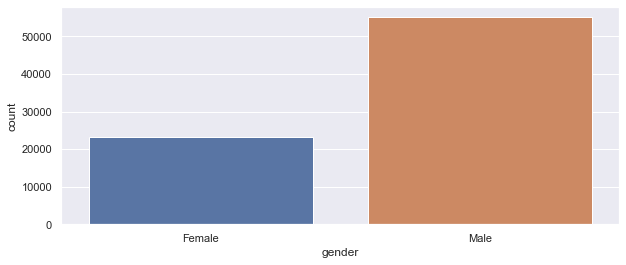

In [117]:
sns.countplot(x = df['gender'])

Parece uma distribuição mais adequada. Infelizmente, há uma maioria de homens (quase o dobro!), o que pode ser um problema ao fazer predições: se há mais homens que mulheres, e as promoções são distribuídas uniformemente entre os gêneros, então haverão mais homens promovidos que mulheres!

##### Idade

In [118]:
df['age'].unique()

array([    35,     30,     34,     39,     45,     31,     33,     28,
           32,     49,     37,     38,     41,     27,     29,     26,
           24,     57,     40,     42,     23,     59,     44,     50,
           56,     20,     25,     47,     36,     46,     60,     43,
           22,     54,     58, 123456,     48,     53,     55,     51,
           52,     21,    -32], dtype=int64)

Possivelmente, esses valores estranhos foram colocados por engano. Vou assumir que o caso `-32` era `32`; e que o `123456` era `56`.

In [119]:
df['age'].replace(-32,32,inplace=True)
df['age'].replace(123456,56,inplace=True)

In [120]:
df['age'].unique()

array([35, 30, 34, 39, 45, 31, 33, 28, 32, 49, 37, 38, 41, 27, 29, 26, 24,
       57, 40, 42, 23, 59, 44, 50, 56, 20, 25, 47, 36, 46, 60, 43, 22, 54,
       58, 48, 53, 55, 51, 52, 21], dtype=int64)

<AxesSubplot:xlabel='age', ylabel='count'>

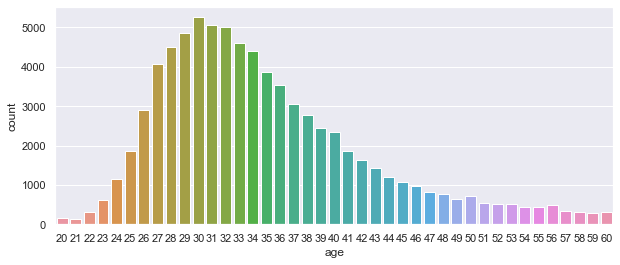

In [121]:
sns.countplot(x=df['age'])

O restante das idades está correto. A distribuição é aproximadamente gaussiana, o que é esperado; e as idades majoritárias são simplesmente as idades de pessoas que já são adultas e longe da idade de aposentadoria, o que também é esperado.

##### Educação

Temos muitos valores nulos nessa _feature_, então, precisamos investigar:

In [122]:
df['education'].unique()

array(["Master's & above", "Bachelor's", nan, 'Below Secondary'],
      dtype=object)

Vamos preencher os valores nulos com algo que aparecerá no gráfico:

In [123]:
df['education'].fillna('Unknown',inplace=True)

<AxesSubplot:xlabel='education', ylabel='count'>

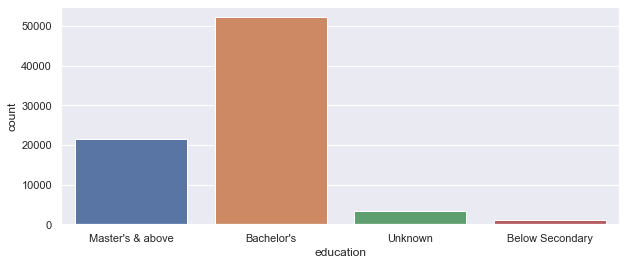

In [124]:
sns.countplot(x = df['education'])

É uma quantidade muito significativa de valores nulos. Estranhamente, falta dado para _"Secondary"_ (semelhante ao ensino médio); os dados saltam diretamente de abaixo do ensino médio (_"Below Secondary"_) para o bacharelado.

Além disso, falamos de uma _empresa_, que certamente teria todos os dados sobre educação de seus funcionários, pois aparecem em seus currículos. Poderíamos ignorar esses dados desconhecidos, mas, por esses motivos - e por ser uma parcela não desprezível - irei os rotular de _"Secondary"_.

Nisso, suponho que os dados faltantes tenham advindo de algum _bug_ no momento de passar os dados para a tabela e, portanto, não se trata de uma simples falta de informação.

In [125]:
df['education'].replace('Unknown','Secondary',inplace=True)

<AxesSubplot:xlabel='education', ylabel='count'>

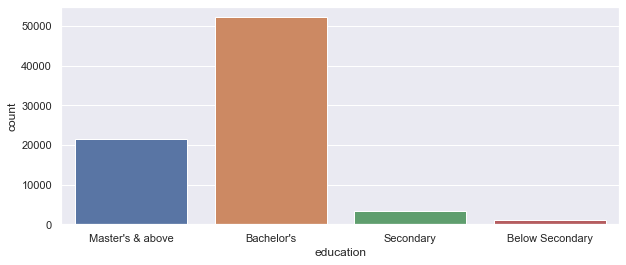

In [126]:
sns.countplot(x = df['education'])

##### Número de treinamentos no ano anterior

Minha suspeita é que os valores nulos em `'no_of_trainings'` sejam equivalentes ao zero, ou seja, pessoas que não fizeram nenhum treinamento no ano anterior.

In [127]:
df['no_of_trainings'].unique()

array([ 1.,  2., nan,  3.,  4.,  7.,  5.,  6.,  8., 10.,  9.])

Vamos checar se o zero faz parte dos valores possíveis:

In [128]:
0 in df['no_of_trainings'].unique()

False

Bom, com um dataset desse tamanho, seria muito improvável que não haja nenhum funcionário que não fez nenhum treinamento no ano anterior, que é a implicação de assumir que esses valores nulos são apenas informação faltante.

É possível que haja uma política interna obrigando que todos os funcionários realizem no mínimo um treinamento por ano, ou que nem todos os valores sejam zeros - alguns podem ser, de fato, informação faltante enquanto outros indicam zero. No entanto, estaríamos fazendo hipóteses demais acerca dos dados!

Então, vamos assumir que indicam zero:

In [129]:
df['no_of_trainings'].fillna(0,inplace=True)

<AxesSubplot:xlabel='no_of_trainings', ylabel='count'>

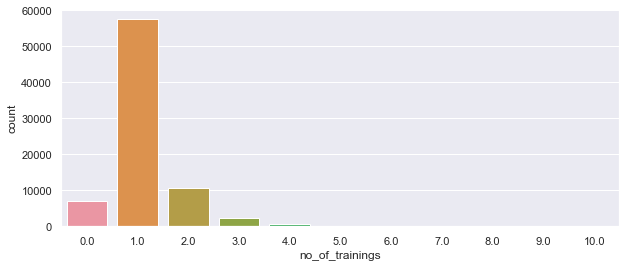

In [130]:
sns.countplot(x = df['no_of_trainings'])

Observamos quase nenhum funcionário com mais de quatro treinamentos, e que há uma concentração em um único treinamento.

Antes de prosseguirmos, devemos checar se o fato de haverem pessoas com zero treinamentos no ano anterior tem alguma relação com serem funcionárias que estão na empresa a apenas um ano (logo, possuem zero treinamentos! Note que não há funcionários a zero anos - seriam pessoas que acabaram de entrar - pois ``'length_of_service'`` não possui nulos e nem valores zero). 

In [131]:
df.query('length_of_service != 1 & no_of_trainings == 0').head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
employee_id,,,,,,,,,,,,
40097,Operations,region_2,Bachelor's,Female,other,0.0,23,4.0,2,0,NaN,0
18013,Procurement,region_2,Master's & above,Female,sourcing,0.0,56,3.0,12,0,NaN,0
68082,Sales & Marketing,region_2,Master's & above,Female,sourcing,0.0,41,1.0,12,0,NaN,0
35420,Operations,region_2,Bachelor's,Female,other,0.0,44,4.0,13,0,NaN,0
41983,Operations,region_2,Bachelor's,Female,sourcing,0.0,33,3.0,5,0,NaN,0


Como filtramos para ver se há pessoas com 0 treinamentos no ano anterior e mais de um ano de serviço, sabemos que nossa suposição estava incorreta: há funcionários veteranos que não realizaram treinamento.

##### Nota do ano anterior

Aqui, vamos realizar um procedimento parecido com a anterior:

In [132]:
df['previous_year_rating'].unique()

array([ 5.,  3.,  1.,  4., nan,  2.])

In [133]:
0 in df['previous_year_rating'].unique()

False

Poderíamos supor que trata-se apenas de uma nota zero, contudo, há uma posibilidade: pessoas que estão há apenas um ano na empresa não obtiveram suas notas ainda! Para descobrir, verificamos quantas pessoas não possuem nota e estão a mais de um ano na empresa:

In [134]:
len(df.query('previous_year_rating.isnull() & length_of_service > 1'))

0

Zero! Então, nossa hipótese estava correta. Poderíamos descartar essas pessoas, se fosse o caso que pessoas com apenas um ano de serviço não pudessem ser promovidas - todavia:

In [135]:
len(df.query('previous_year_rating.isnull() & is_promoted == 1'))

339

Há uma pequena quantidade de pessoas sem nota que foram promovidas! É raro, mas indica que é possível. Portanto, para que o modelo seja capaz de analisar esses casos, vamos trasnformar em zero:

In [136]:
df['previous_year_rating'].fillna(0,inplace=True)

<AxesSubplot:xlabel='previous_year_rating', ylabel='count'>

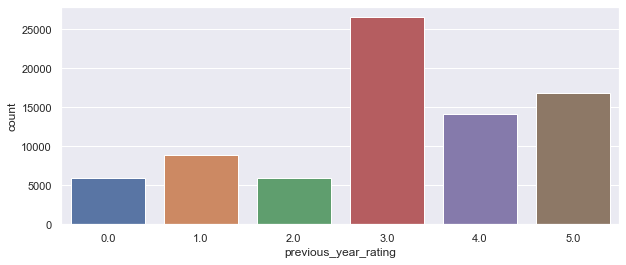

In [137]:
sns.countplot(x = df['previous_year_rating'])

Nada de surpreendente por aqui. A maioria dos funcionários está na média. É possível que a empresa use um sistema análogo a _"estrelas"_ de hotéis, onde é possível ter apenas notas inteiras e a menor nota é 1.

##### Nota média de treinamento

In [138]:
df['avg_training_score'].unique()

array([49., 60., 50., 73., 85., 59., 63., 83., 54., 77., 80., 84., 51.,
       46., nan, 57., 70., 68., 79., 44., 72., 61., 48., 58., 87., 47.,
       52., 88., 71., 65., 62., 53., 75., 78., 91., 82., 69., 74., 90.,
       86., 92., 67., 89., 56., 76., 81., 45., 39., 94., 93., 64., 66.,
       42., 96., 40., 55., 99., 43., 95., 97., 41., 98.])

In [139]:
len(df.query('avg_training_score.isnull() & no_of_trainings != 0'))

2612

No caso dessas notas, elas são referentes a treinamentos **atuais** e não **completos** (diferente da ``no_of_trainings``). Por isso há muitas pessoas que têm ``no_of_trainings != 0`` e mesmo assim não possuem notas.

Vamos ver quantos dados são relativos ao total. Para tanto, vou colocá-los como zero e plotar:

In [140]:
df['avg_training_score'].fillna(0.0,inplace=True)

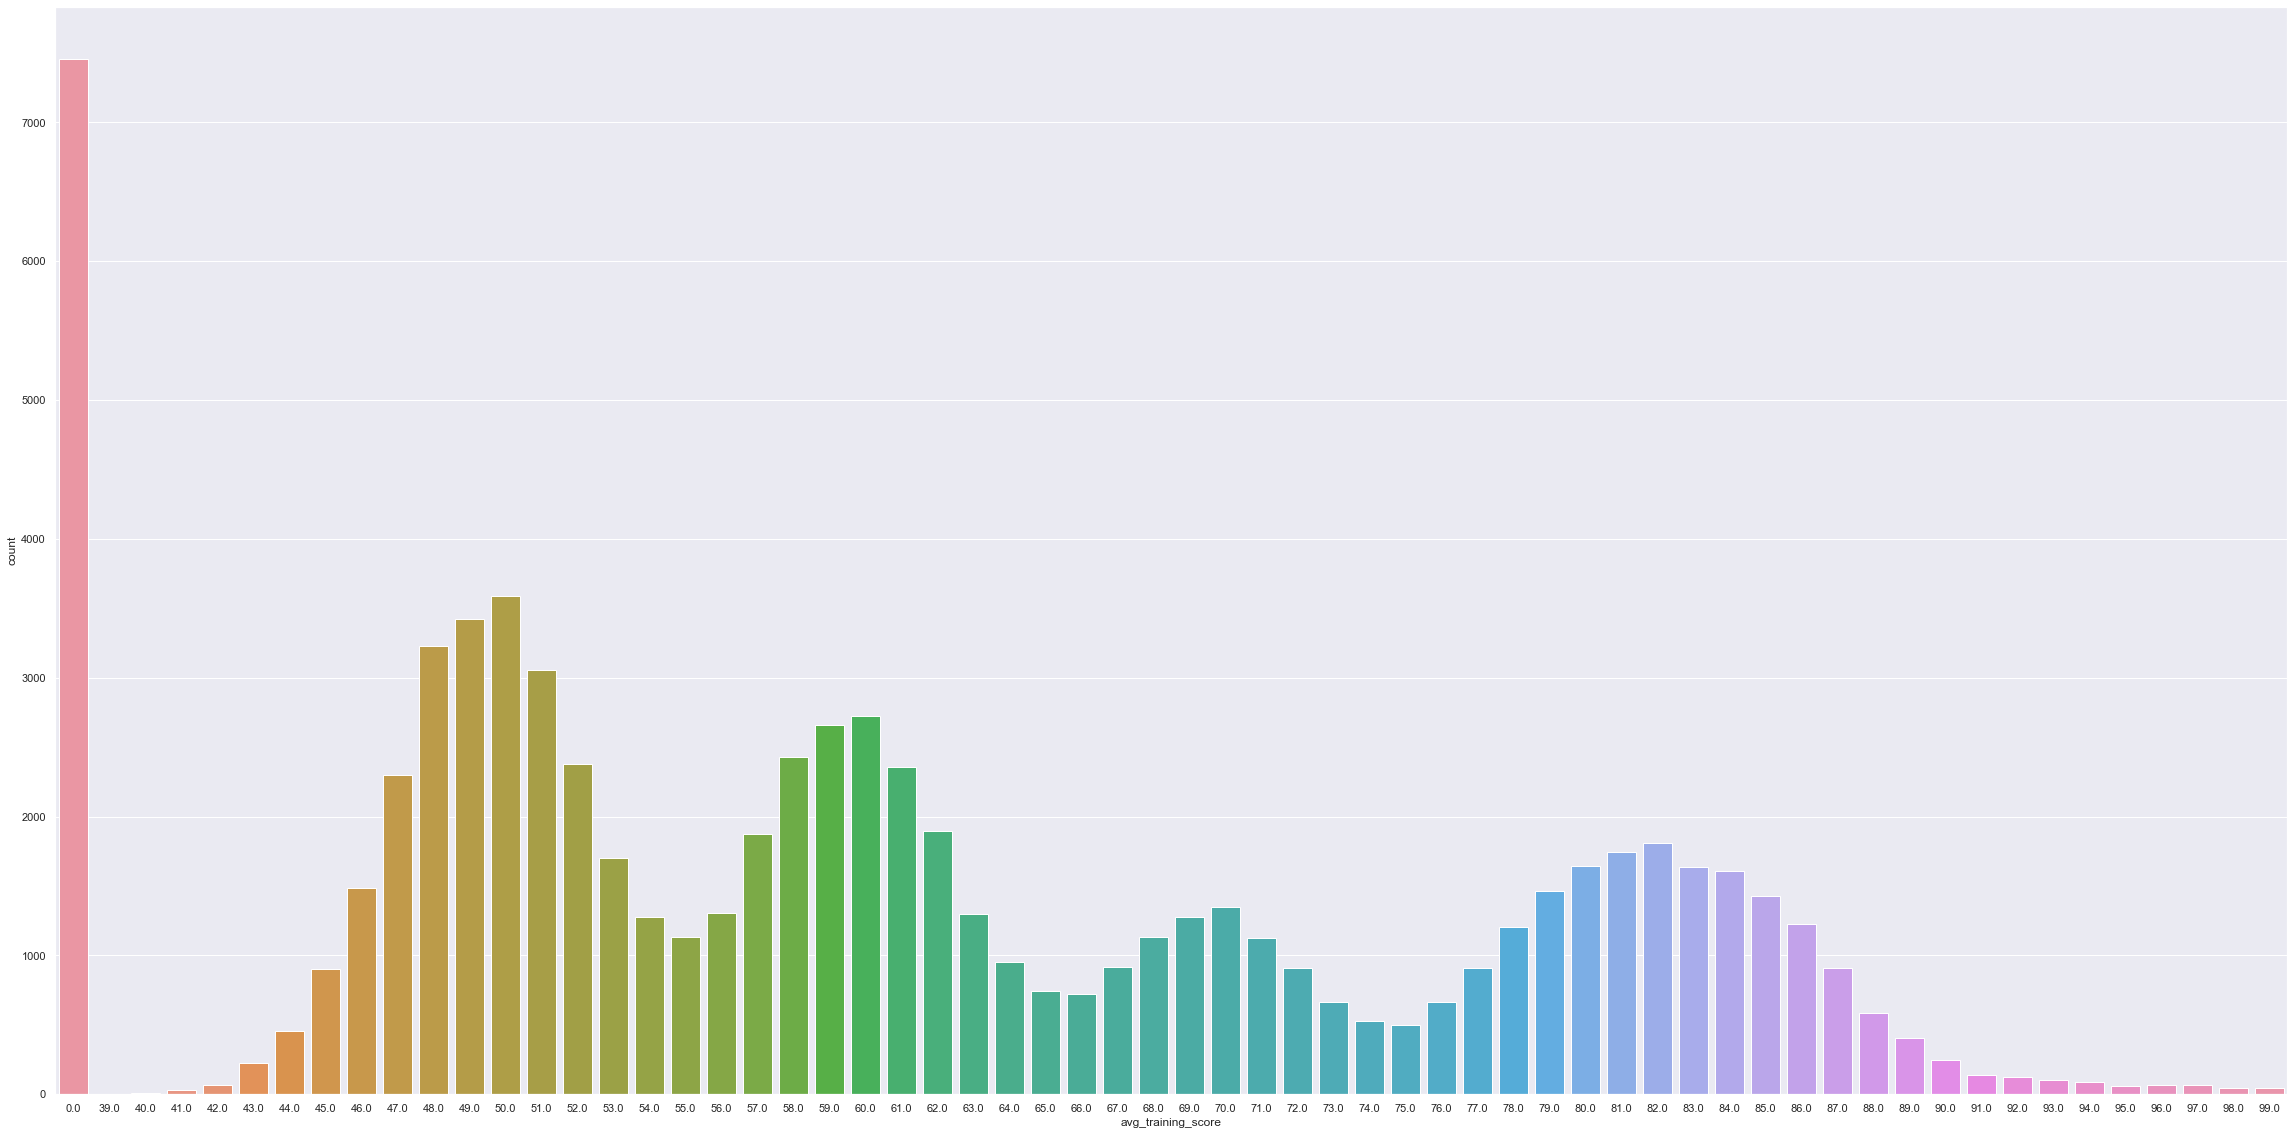

In [141]:
sns.set(rc={"figure.figsize":(40, 20)})

sns.countplot(x=df['avg_training_score'])

sns.set(rc={"figure.figsize":(10, 4)})

Talvez fique um pouco difícil de ler, mas fica claro que o zero é uma avassaladora maioria, logo, não podemos ignorá-los! Porém, se nossa hipótese estiver correta e trata-se apenas de pessoas que não fizeram nenhum treinamento, podemos supor que, em outra situação, essas pessoas teriam feito algum treinamento naquele ano. 

Nessa suposição, essas pessoas teriam _alguma_ nota. Então, vamos "fingir" que essas pessoas tem uma nota. Para tanto, devemos atribuir a cada pessoa uma nota individual. Mas, como fazer isso? A forma mais adequada seria distribuir aleatoriamente; no entanto, precisamos determinar uma distribuição de probabilidades.

Há, é claro, muitas formas de fazer isso. Podemos realizar uma análise matemática profunda e detalhada da distribuição das notas que temos, e criar assim uma distribuição muito precisa. Porém, como trata-se de um projeto para treino, irei usar uma distribuição gaussiana - que é distribuição contínua que faz o _mínimo_ de hipóteses adicionais - com mínimo ``39.0``, máximo ``99.0``, centrada na média aritmética das notas e com o mesmo desvio padrão delas. Como só podemos ter valores inteiros, mas a gaussiana é uma distribuição contínua (valores reais), vamos arredondá-los.

In [142]:
np.random.seed(1) # Aqui definimos uma seed, para que os valores aleatórios sejam sempre os mesmos permitindo reprodutibilidade.

total = len(df[df['avg_training_score']==0]) # Número de dados aleatórios que precisaremos.

media = df[df['avg_training_score']!=0]['avg_training_score'].mean() # Média dos valores de média de notas

desv = df[df['avg_training_score']!=0]['avg_training_score'].std() # Desvio padrão dos mesmos dados.

# Abaixo, calculo os valores da gaussiana. Porém, não é possível limitá-la (ela é definida no espaço todo), então, gero
# um excedente de valores e depois jogo fora os que estão além do limite, após os arredondar. Se sobrarem alguns, também
# os descarto.

notas_aleatorias =  np.random.normal(media,desv,int(total*2)) # Calculando os valores com excedente.

notas_aleatorias = np.round(notas_aleatorias) # Arredondando.

notas_aleatorias = notas_aleatorias[(notas_aleatorias >= 39) & (notas_aleatorias <= 99)] # Cortando os fora dos limites.

notas_aleatorias = notas_aleatorias[:total] # Removendo os que sobraram.

Agora, separamos a coluna com os valores nulos e a substituímos por uma coluna com os valores que geramos!

In [143]:
df1 = df[df['avg_training_score']==0].copy()

df = df.drop(df1.index)

Aqui, ploto os dados sem os valores nulos, para referência:

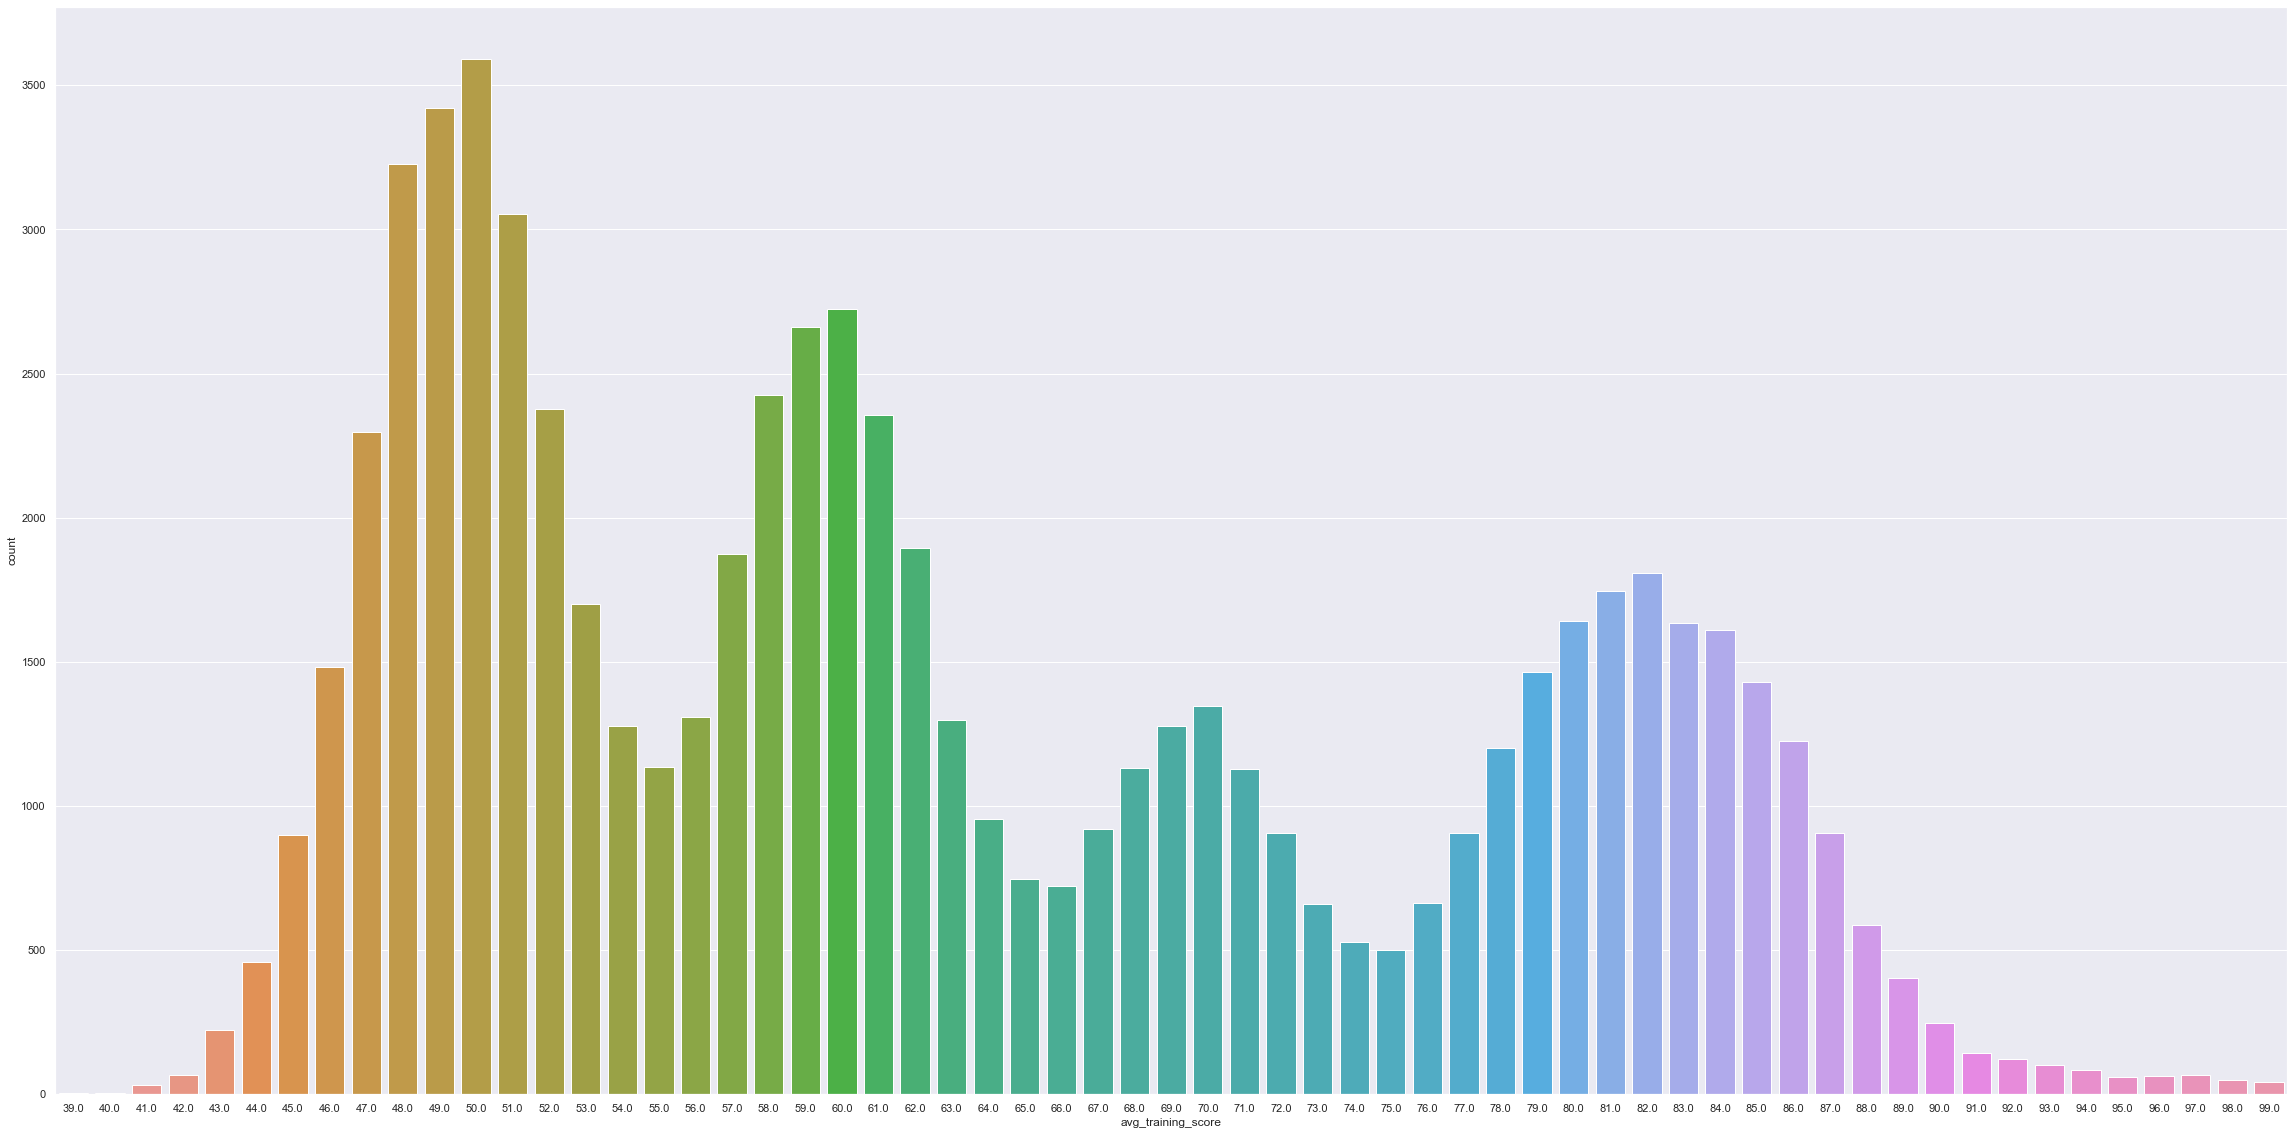

In [144]:
sns.set(rc={"figure.figsize":(40, 20)})

sns.countplot(x=df['avg_training_score'])

sns.set(rc={"figure.figsize":(10, 4)})

In [145]:
df1.drop('avg_training_score',axis=1,inplace=True)

In [146]:
df1['avg_training_score'] = pd.Series(notas_aleatorias,df1.index)

In [147]:
df = pd.concat([df,df1])

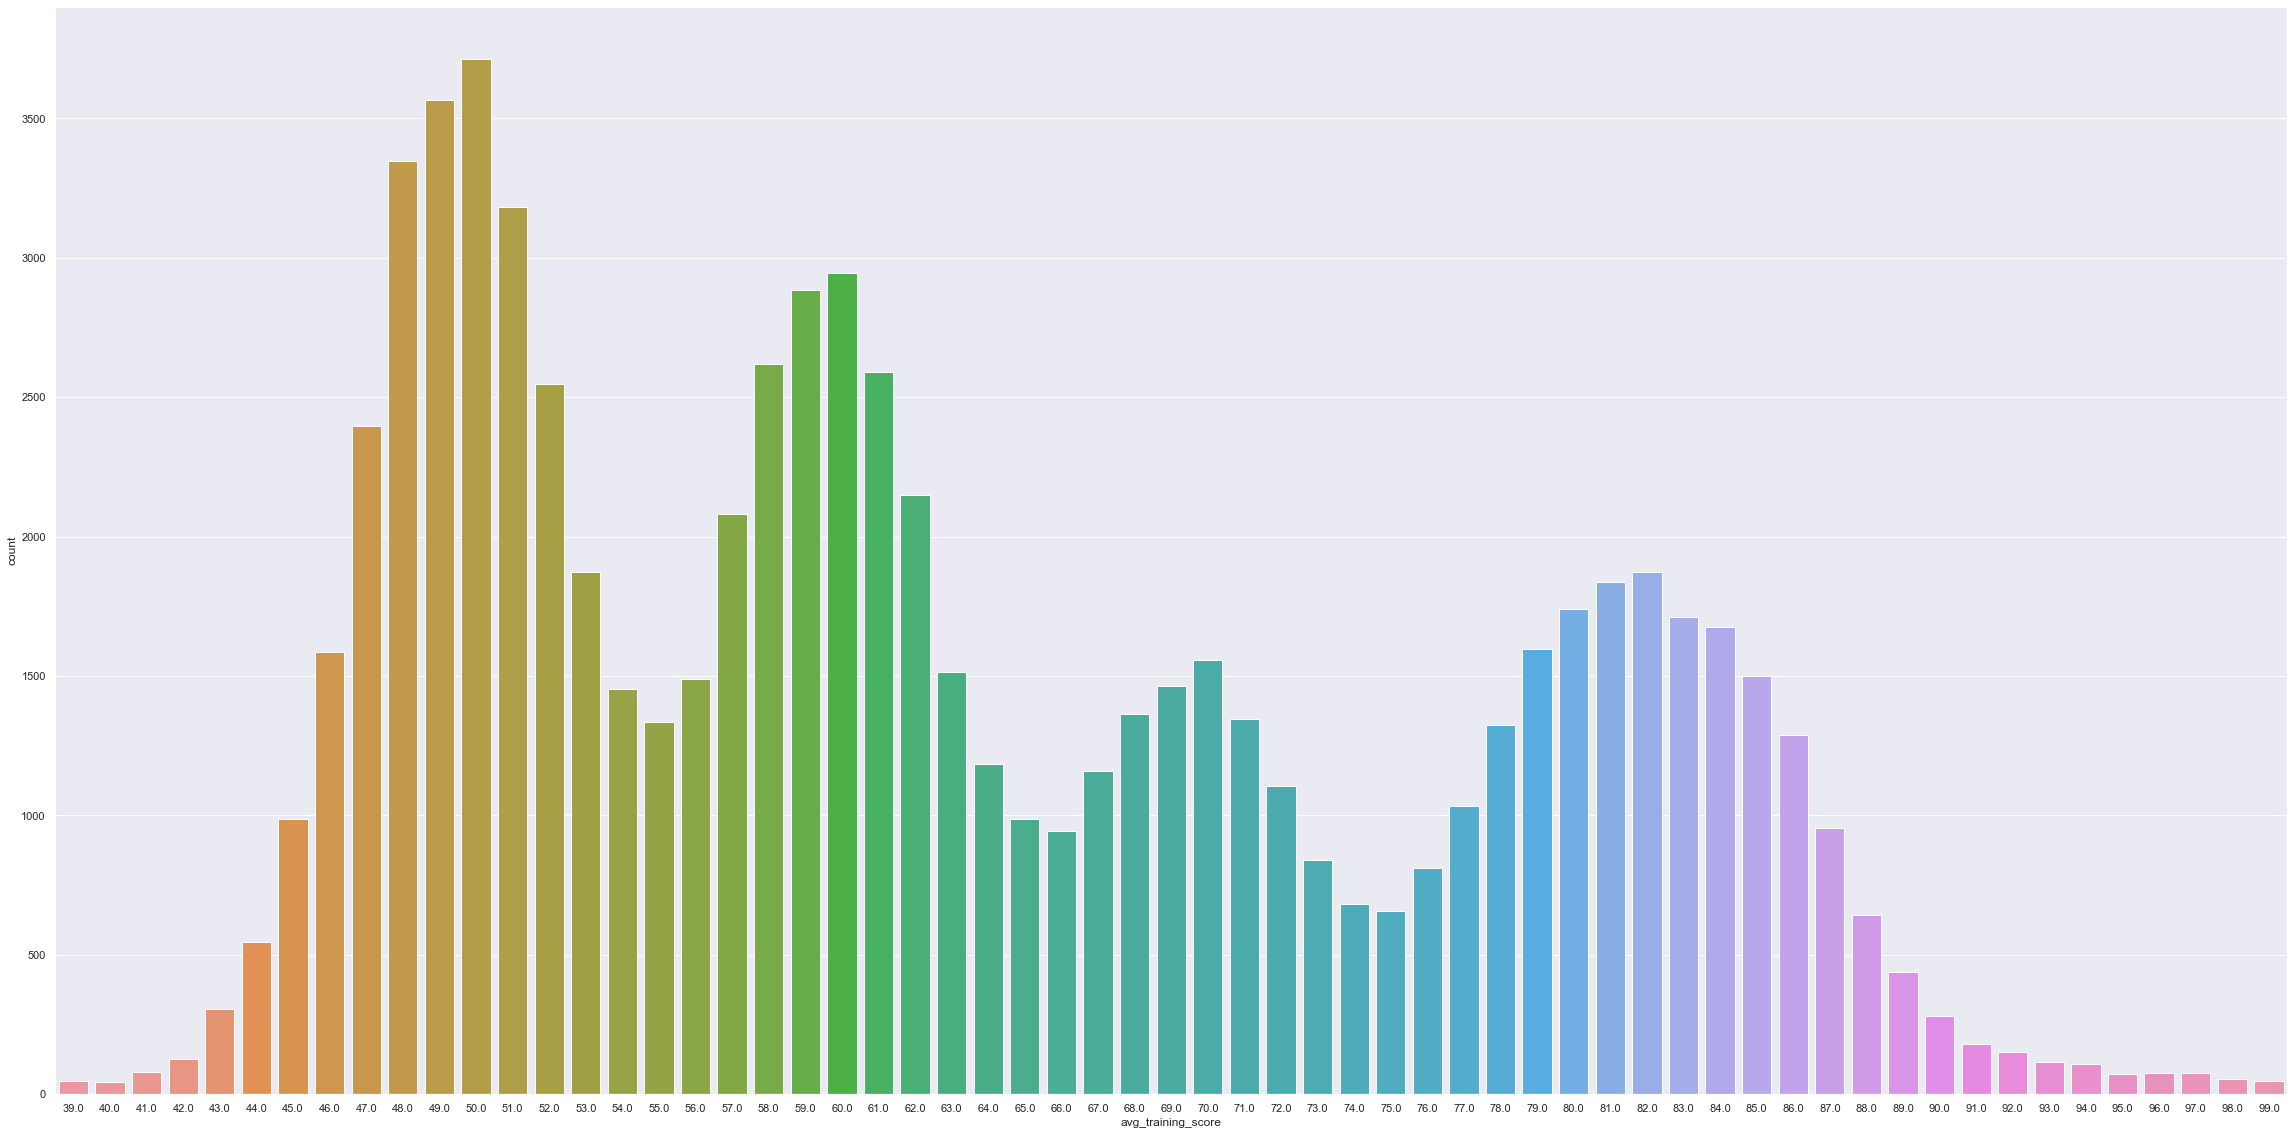

In [148]:
sns.set(rc={"figure.figsize":(40, 20)})

sns.countplot(x=df['avg_training_score'])

sns.set(rc={"figure.figsize":(10, 4)})

Ao final, obtivemos uma distribuição semelhante à que começamos, porém com mais valores! Dessa forma, integramos os valores nulos sem precisar descartar.

Sobre a distribuição, é um tanto semelhante a uma sobreposição de quatro gaussianas, como se houvessem alguns _"patamares"_ onde se concentram os funcionários. Podemos utilizar esses patamares como categorias, se desejarmos!

Além disso, o fato de iniciar em ``39.0`` indica um possível "ponto de corte" para esses treinamentos; uma nota mínima para que o treinamento seja considerado completo - não indicando, portanto, qualquer propriedade relevante.

#### Ajustes Finais

Ainda há alguns outros pequenos detalhes nas features categóricas:

In [149]:
df['department'].unique()

array(['Sales & Marketing', 'Operations', 'Technology', 'Analytics',
       'R&D', 'Finance', 'Procurement', 'HR', 'Legal',
       'quem trouxe quenga'], dtype=object)

Claramente temos um dado errado! Porém:

In [150]:
print(np.round(100*len(df[df['department']=='quem trouxe quenga'])/len(df['department']),3),'%')

0.041 %


São apenas ``0.041%`` do total de dados! Então, não perderemos muito se só os apagarmos. Infelizmente, não há uma forma clara de organizar esses dados em uma das categorias, como era possível nos outros. Então:

In [151]:
df1 = df[df['department'] == 'quem trouxe quenga']

df.drop(df1.index,inplace=True)

In [152]:
df['department'].unique()

array(['Sales & Marketing', 'Operations', 'Technology', 'Analytics',
       'R&D', 'Finance', 'Procurement', 'HR', 'Legal'], dtype=object)

Última correção:

In [153]:
df['region'].unique()

array(['region_7', 'region_22', 'region_19', 'region_23', 'region_26',
       'region_2', 'region_20', 'region_34', 'region_1', 'region_4',
       'region_29', 'region_31', 'region_15', 'region_11', 'region_5',
       'region_17', 'region_13', 'region_16', 'region_25', 'region_10',
       'region_27', 'region_30', 'region_21', 'region_8', 'region_14',
       'region_32', 'region_6', 'region_12', 'region_33', 'region_24',
       'region_3', 'region_9', 'region_28', 'region_18',
       'casa da lu na suecia'], dtype=object)

Há uma região claramente errada. Primeiro, vou verificar se não há uma região "faltando" - por exemplo, se há regiões 4 e 6 mas não uma região 5; isso implicaria que a categoria faltante era para ser uma das regiões. Para isso, vamos organizar as regiões:

In [154]:
np.sort(df['region'].unique())

array(['casa da lu na suecia', 'region_1', 'region_10', 'region_11',
       'region_12', 'region_13', 'region_14', 'region_15', 'region_16',
       'region_17', 'region_18', 'region_19', 'region_2', 'region_20',
       'region_21', 'region_22', 'region_23', 'region_24', 'region_25',
       'region_26', 'region_27', 'region_28', 'region_29', 'region_3',
       'region_30', 'region_31', 'region_32', 'region_33', 'region_34',
       'region_4', 'region_5', 'region_6', 'region_7', 'region_8',
       'region_9'], dtype=object)

Infelizmente, não era o caso. Todavia, se verificarmos a quantidade de dados errados:

In [155]:
print(np.round(100*len(df[df['region']=='casa da lu na suecia'])/len(df['region']),3),'%')

0.008 %


É uma quantidade até menor que o caso anterior! Então, vamos apenas descartá-los.

In [156]:
df1 = df[df['region'] == 'casa da lu na suecia']

df.drop(df1.index,inplace=True)

Finalmente, vamos olhar o nosso dataset limpo:

In [157]:
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
employee_id,,,,,,,,,,,,
65438,Sales & Marketing,region_7,Master's & above,Female,sourcing,1.0,35,5.0,8,0,49.0,0
65141,Operations,region_22,Bachelor's,Male,other,1.0,30,5.0,4,0,60.0,0
7513,Sales & Marketing,region_19,Bachelor's,Male,sourcing,1.0,34,3.0,7,0,50.0,0
2542,Sales & Marketing,region_23,Bachelor's,Male,other,2.0,39,1.0,10,0,50.0,0
48945,Technology,region_26,Bachelor's,Male,other,1.0,45,3.0,2,0,73.0,0


In [158]:
df.describe()

,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
count,78260.000000,78260.000000,78260.000000,78260.000000,78260.000000,78260.000000,78260.000000
mean,1.145707,34.840966,3.079709,5.849796,0.022642,63.518068,-0.240480
std,0.683360,7.693660,1.499157,4.248614,0.148762,13.351624,0.549335
min,0.000000,20.000000,0.000000,1.000000,0.000000,39.000000,-1.000000
25%,1.000000,29.000000,2.000000,3.000000,0.000000,51.000000,-1.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,60.000000,0.000000
75%,1.000000,39.000000,4.000000,7.000000,0.000000,76.000000,0.000000
max,10.000000,60.000000,5.000000,37.000000,1.000000,99.000000,1.000000


In [159]:
df.describe(include=['object'])

,department,region,education,gender,recruitment_channel
count,78260,78260,78260,78260,78260
unique,9,34,4,2,3
top,Sales & Marketing,region_2,Bachelor's,Male,other
freq,24155,17631,52215,55058,43502


In [160]:
df.isnull().sum()

department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

Tudo parece estar em ordem! Podemos separar os dois datasets de treino e de teste, utilizando o marcador -1 que havíamos colocado:

In [161]:
dftest = df[df['is_promoted'] == -1].copy()
dftest.drop('is_promoted',axis=1,inplace=True)

In [162]:
dftrain = df.drop(dftest.index).copy()

In [163]:
dftrain.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
employee_id,,,,,,,,,,,,
65438,Sales & Marketing,region_7,Master's & above,Female,sourcing,1.0,35,5.0,8,0,49.0,0
65141,Operations,region_22,Bachelor's,Male,other,1.0,30,5.0,4,0,60.0,0
7513,Sales & Marketing,region_19,Bachelor's,Male,sourcing,1.0,34,3.0,7,0,50.0,0
2542,Sales & Marketing,region_23,Bachelor's,Male,other,2.0,39,1.0,10,0,50.0,0
48945,Technology,region_26,Bachelor's,Male,other,1.0,45,3.0,2,0,73.0,0


In [164]:
dftrain.describe()

,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
count,54779.000000,54779.000000,54779.000000,54779.000000,54779.000000,54779.000000,54779.000000
mean,1.145457,34.865952,3.078935,5.866500,0.022709,63.626536,0.085087
std,0.685290,7.699603,1.496419,4.265647,0.148977,13.323619,0.279014
min,0.000000,20.000000,0.000000,1.000000,0.000000,39.000000,0.000000
25%,1.000000,29.000000,2.000000,3.000000,0.000000,52.000000,0.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,61.000000,0.000000
75%,1.000000,39.000000,4.000000,7.000000,0.000000,75.000000,0.000000
max,10.000000,60.000000,5.000000,37.000000,1.000000,99.000000,1.000000


In [165]:
dftest.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score
employee_id,,,,,,,,,,,
8724,Technology,region_26,Bachelor's,Male,sourcing,1.0,24,0.0,1,0,77.0
74430,HR,region_4,Bachelor's,Female,other,1.0,31,3.0,5,0,51.0
72255,Sales & Marketing,region_13,Bachelor's,Male,other,1.0,31,1.0,4,0,47.0
38562,Procurement,region_2,Bachelor's,Female,other,0.0,31,2.0,9,0,65.0
64486,Finance,region_29,Bachelor's,Male,sourcing,1.0,30,4.0,7,0,61.0


In [166]:
dftest.describe()

,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score
count,23481.000000,23481.000000,23481.000000,23481.000000,23481.000000,23481.000000
mean,1.146288,34.782675,3.081513,5.810826,0.022486,63.265023
std,0.678851,7.679626,1.505555,4.208441,0.148262,13.413604
min,0.000000,20.000000,0.000000,1.000000,0.000000,39.000000
25%,1.000000,29.000000,2.000000,3.000000,0.000000,51.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,60.000000
75%,1.000000,39.000000,4.000000,7.000000,0.000000,76.000000
max,9.000000,60.000000,5.000000,34.000000,1.000000,99.000000


In [167]:
dftest.isnull().sum()

department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
awards_won?             0
avg_training_score      0
dtype: int64

In [168]:
dftrain.isnull().sum()

department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

Pronto!

### Predição

Como temos muitas features de tipos diferentes, vamos usar um _Random Forest_ para realizar as predições.

Primeiro, vamos criar os _dummies_, ou seja, converter as features categóricas em diferentes colunas com valor 1 e 0:

In [169]:
encoding_train = pd.get_dummies(dftrain)

In [170]:
encoding_train.columns

Index(['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'awards_won?', 'avg_training_score', 'is_promoted',
       'department_Analytics', 'department_Finance', 'department_HR',
       'department_Legal', 'department_Operations', 'department_Procurement',
       'department_R&D', 'department_Sales & Marketing',
       'department_Technology', 'region_region_1', 'region_region_10',
       'region_region_11', 'region_region_12', 'region_region_13',
       'region_region_14', 'region_region_15', 'region_region_16',
       'region_region_17', 'region_region_18', 'region_region_19',
       'region_region_2', 'region_region_20', 'region_region_21',
       'region_region_22', 'region_region_23', 'region_region_24',
       'region_region_25', 'region_region_26', 'region_region_27',
       'region_region_28', 'region_region_29', 'region_region_3',
       'region_region_30', 'region_region_31', 'region_region_32',
       'region_region_33', 'region_region_34', 'regio

Funcionou! Agora temos uma coluna para cada categoria!

Agora, vou fazer alguns dados de teste usando ``train_test_split``:

In [171]:
X_train, X_test, y_train, y_test = train_test_split(encoding_train.drop('is_promoted',axis = 1),encoding_train['is_promoted'].copy(), test_size = 0.25, random_state = 42)

Finalmente, podemos criar nosso modelo com o ``scikit_learn``:

In [172]:
rf = RandomForestClassifier(
    max_depth=25,
    n_estimators=200,
    min_samples_split=50,
    criterion='entropy',
    oob_score=True,
    random_state=42
)

rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=25, min_samples_split=50,
                       n_estimators=200, oob_score=True, random_state=42)

Feito o fit com os dados de treino, podemos utilizar os dados de teste para, obviamente, testar o modelo:

In [173]:
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.924
Mean accuracy score: 0.926


E fazemos uma matriz de confusão:

[Text(0, 0.5, 'Promoted'), Text(0, 1.5, 'Not Promoted')]

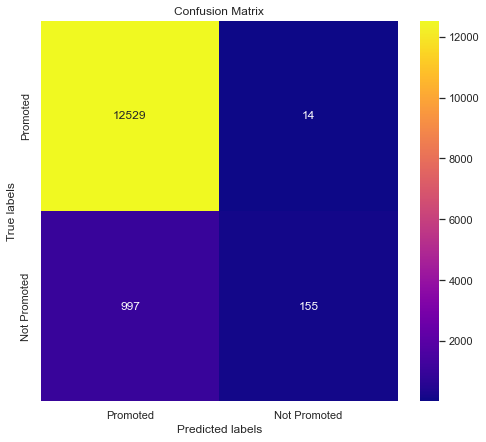

In [174]:
cm = confusion_matrix(y_test, predicted)
fig, (ax) = plt.subplots(1, 1, figsize=(8,7))
sns.heatmap(cm, annot=True, ax = ax,fmt='g',cmap = 'plasma')
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix')
sns.set(font_scale=1.5)
ax.xaxis.set_ticklabels(['Promoted', 'Not Promoted'])
ax.yaxis.set_ticklabels(['Promoted', 'Not Promoted'])

Usando ela, podemos calcular a sensitividade e a precisão:

In [175]:
sensitividade = 12529/(12529 + 14)

print(np.round(sensitividade,4)*100,"%")

99.89 %


In [176]:
precisao = 12529/(12529 + 997)
print(np.round(precisao,4)*100,"%")

92.63 %


Observamos que a acurácia, precisão e sensitividade estão muito altas. Ou seja, o modelo conseguiu prever muito bem! No entanto, pode ser um caso de overfitting. Não é extremo, pois não obtivemos algo _muito_ ridículo como acurácia 99.99%, mas ainda sim é possível.

Finalmente, vamos utilizar nosso modelo para gerar a coluna de ``is_promoted`` nos dados:

In [177]:
dftest_encoding = pd.get_dummies(dftest)

In [178]:
is_promoted = rf.predict(dftest_encoding)

In [179]:
is_promoted = pd.DataFrame(is_promoted)

In [188]:
is_promoted.set_index(dftest.index,inplace=True)

In [189]:
dftest['is_promoted'] = is_promoted

In [190]:
dftest.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
employee_id,,,,,,,,,,,,
8724,Technology,region_26,Bachelor's,Male,sourcing,1.0,24,0.0,1,0,77.0,0
74430,HR,region_4,Bachelor's,Female,other,1.0,31,3.0,5,0,51.0,0
72255,Sales & Marketing,region_13,Bachelor's,Male,other,1.0,31,1.0,4,0,47.0,0
38562,Procurement,region_2,Bachelor's,Female,other,0.0,31,2.0,9,0,65.0,0
64486,Finance,region_29,Bachelor's,Male,sourcing,1.0,30,4.0,7,0,61.0,0


In [191]:
dftest.describe()

,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
count,23481.000000,23481.000000,23481.000000,23481.000000,23481.000000,23481.000000,23481.000000
mean,1.146288,34.782675,3.081513,5.810826,0.022486,63.265023,0.011201
std,0.678851,7.679626,1.505555,4.208441,0.148262,13.413604,0.105241
min,0.000000,20.000000,0.000000,1.000000,0.000000,39.000000,0.000000
25%,1.000000,29.000000,2.000000,3.000000,0.000000,51.000000,0.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,60.000000,0.000000
75%,1.000000,39.000000,4.000000,7.000000,0.000000,76.000000,0.000000
max,9.000000,60.000000,5.000000,34.000000,1.000000,99.000000,1.000000


Pronto! Agora fizemos as previsões que queríamos.